In [1]:
!pip install torchmetrics

In [2]:
import os
import torch
import numpy as np
import rasterio
from torch.utils.data import Dataset,DataLoader,random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score,f1_score
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import random
from torchsummary import summary
import scipy.ndimage as nd
import torch
import torchvision
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryJaccardIndex



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Dataset and Dataloader Class

In [3]:
class AlluvialBarDataset(Dataset):
  def __init__(self,img_dir,mask_dir,transform = None ):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.img_list = sorted(os.listdir(img_dir))
    self.mask_list = sorted(os.listdir(mask_dir))
    self.transform = transform

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir,self.img_list[idx])
    mask_path = os.path.join(self.mask_dir,self.mask_list[idx])
###########################################if in raster format###############
    # with rasterio.open(img_path) as src:
    #   img = src.read().astype(np.float32)
    # with rasterio.open(mask_path) as src:
    #   mask = src.read().astype(np.float32)

###########################################if in numpy format###############
    img = np.load(img_path)     #likely (C,H,W)
    mask = np.load(mask_path)   #likely (1,H,W)

# --- Ensure image is (H, W, C) for Albumnetations
    if img.ndim == 3 :
       img = np.transpose(img, (1, 2, 0))  # → (H, W, C)
# --- Ensure mask is (H, W) for Albumnetations by removing the singleton using squeeze
    if mask.ndim == 3:
            mask = np.squeeze(mask, axis=0)


#Resize to ensure they have same dimensions
    #Get the minimum height and width among image and mask
    min_height = min(img.shape[0], mask.shape[0])
    min_width = min(img.shape[1], mask.shape[1])

#Resize image and mask using array slicing
    img = img[:min_height, :min_width, ...]  # ... preserves other dimensions(channel) for image
    mask = mask[:min_height, :min_width]


    if self.transform :
        augmented  = self.transform(image =img,mask = mask)
        img = augmented['image']
        mask = augmented['mask']

# Convert to tensor and permute channels to first dimension and bring back the singleton using the unsqeeze function
        img = torch.tensor(img).permute(2, 0, 1)  # (C, H, W)
        mask = torch.tensor(mask).unsqueeze(0)    # (1, H, W)

    # else :
    #     img = torch.tensor(img).permute(2,0,1)
    #     mask = torch.from_numpy(mask).unsqueeze(0)



    return img,mask

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.2),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.2)
])


<ipython-input-3-451847dc4c48>:65: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
img_dir = '/content/drive/MyDrive/FirstDeepLearningProject/7band_images_npy_normalized'
mask_dir = '/content/drive/MyDrive/FirstDeepLearningProject/label_npy'
dataset = AlluvialBarDataset(img_dir,mask_dir,transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset)- train_size


train_dataset,test_dataset = random_split(dataset,[train_size,test_size])

train_loader = DataLoader(train_dataset,batch_size=8,shuffle=True,drop_last=True)
test_loader = DataLoader(train_dataset,batch_size=8,shuffle= False)

Sanity Checks

In [6]:
image, mask = dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
# Expected output: Image shape: (8, 256, 256)


Image shape: torch.Size([7, 256, 256]), Mask shape: torch.Size([1, 256, 256])


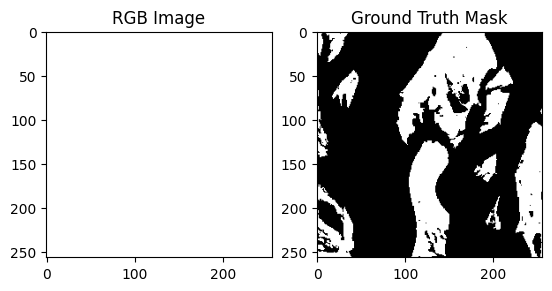

In [7]:
# Select the RGB channels (indices 2, 1, 0 based on the band order)
# Permute them to be in (H, W, C) format for matplotlib
img, mask = dataset[130]
rgb_img = img[[2, 1, 0], :, :].permute(1, 2, 0)

plt.subplot(1, 2, 1)
# Display the RGB image
plt.imshow(rgb_img)
plt.title("RGB Image")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

plt.show() # Add plt.show() to display the plot immediately

Mask shape: (1, 256, 256)
Mask Data Type: uint8
Unique values in mask: [0 1]


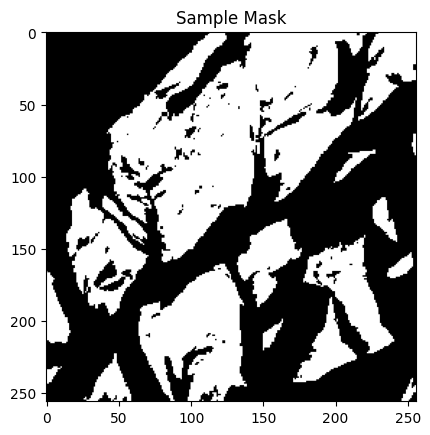

In [8]:
sample_mask_path = os.path.join(mask_dir, os.listdir(mask_dir)[200])
mask_array = np.load(sample_mask_path)

print("Mask shape:", mask_array.shape)
print("Mask Data Type:",mask_array.dtype)
print("Unique values in mask:", np.unique(mask_array))

# Visualize
# Squeeze the mask_array to remove the singleton dimension
plt.imshow(np.squeeze(mask_array), cmap='gray')
plt.title("Sample Mask")
plt.show()

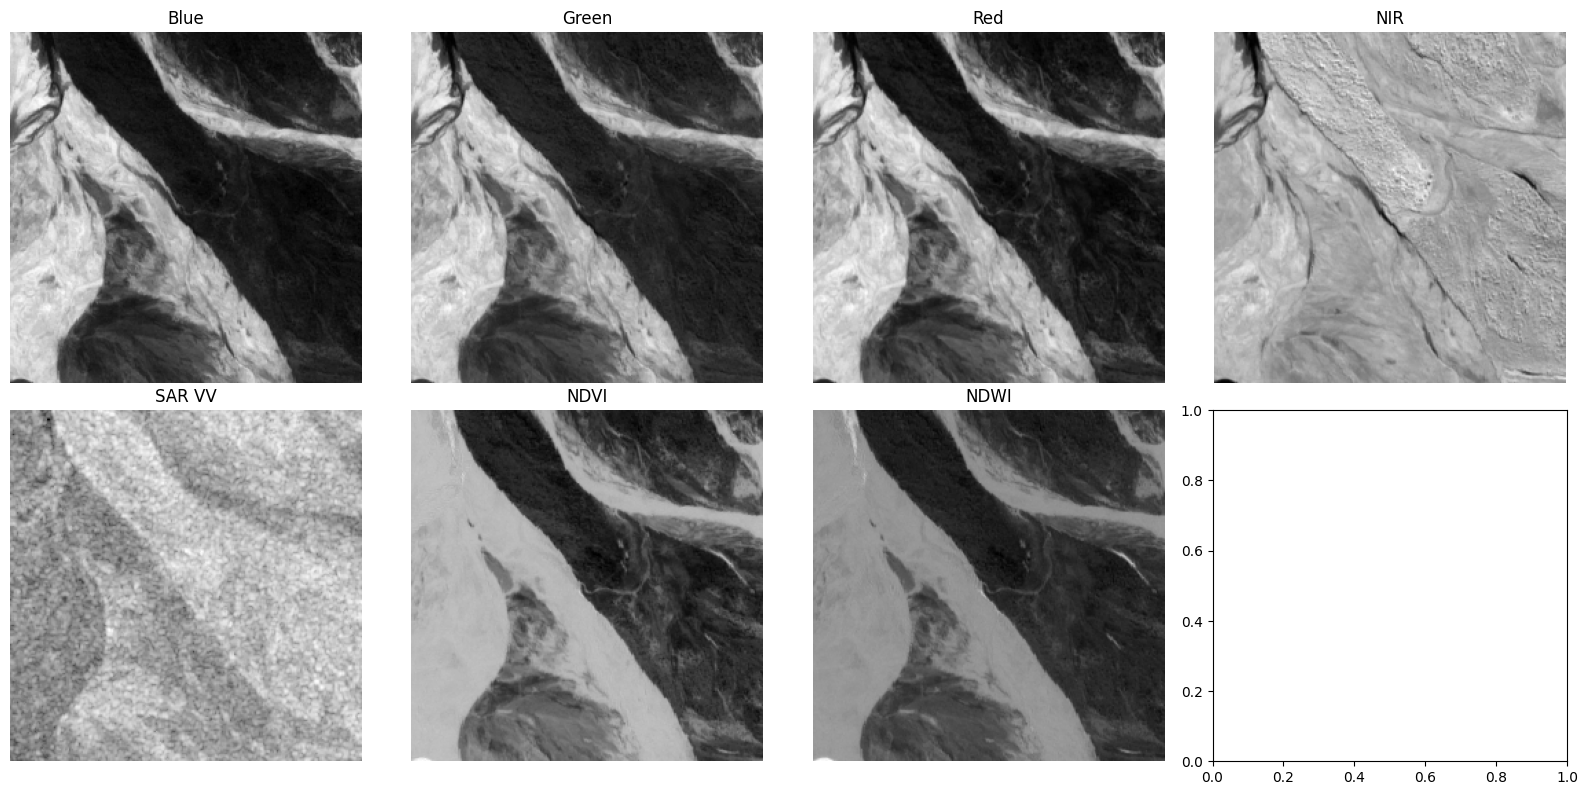

In [9]:
def visualize_bands(image):
    band_names = ['Blue', 'Green', 'Red', 'NIR', 'SAR VV','NDVI', 'NDWI']
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.ravel()

    for i in range(len(band_names)):
        band = image[i].numpy()
        axs[i].imshow(band, cmap='gray')
        axs[i].set_title(band_names[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example
visualize_bands(dataset[101][0])


In [10]:
def check_band_stats(image):
    for i, name in enumerate( ['Blue', 'Green', 'Red', 'NIR', 'SAR VV','NDVI', 'NDWI']):
        band = image[i].numpy()
        print(f"{name:8s} → min: {band.min():.3f}, max: {band.max():.3f}, mean: {band.mean():.3f}, std: {band.std():.3f}")

# Example
check_band_stats(dataset[101][0])


Blue     → min: 1.898, max: 9.451, mean: 4.614, std: 2.200
Green    → min: 2.098, max: 10.580, mean: 5.318, std: 2.283
Red      → min: 1.694, max: 11.114, mean: 5.261, std: 2.669
NIR      → min: 0.000, max: 1.000, mean: 0.651, std: 0.098
SAR VV   → min: 0.000, max: 1.000, mean: 0.674, std: 0.113
NDVI     → min: 0.141, max: 0.604, mean: 0.345, std: 0.111
NDWI     → min: 0.184, max: 0.664, mean: 0.353, std: 0.092


In [ ]:
# for batch_imgpatch,batch_maskpatch in dataloader:
#   print(batch_imgpatch)
#   print(batch_maskpatch)
#   print("--"*100)

Streaming output truncated to the last 5000 lines.
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  8.9187e-02,  2.2800e-01,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  3.3043e-02,  4.6981e-02,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 9.3819e-03,  2.6874e-02,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]],


        [[[ 4.0549e+00,  4.1569e+00,  3.8431e+00,  ...,  8.2118e+00,
            8.2275e+00,  8.0549e+00],
          [ 3.8431e+00,  3.9608e+00,  3.8196e+00,  ...,  8.1412e+00,
            8.0863e+00,  8.0314e+00],
          [ 3.9843e+00,  3.8078e+00,  3.8588e+00,  ...,  8.2980e+00,
            7.9843e+00,  7.9216e+00],
          ...,
          [ 3.2549e+0

Simple Trial Architecture

In [ ]:
# class SimpleSegnet(nn.Module):
#   def __init__(self,in_channels):
#    super(SimpleSegnet,self).__init__()
#    self.encoder = nn.Sequential(
#        nn.Conv2d(in_channels,16,kernel_size = 3,padding = 1),
#        nn.ReLU(),
#        nn.MaxPool2d(kernel_size = 2,stride = 2),
#        nn.Conv2d(16,32,kernel_size = 3,padding = 1),
#        nn.ReLU(),
#        nn.MaxPool2d(kernel_size = 2,stride = 2)
#    )

#    self.decoder = nn.Sequential(
#        nn.ConvTranspose2d(32,16,kernel_size = 2,stride = 2) ,
#        nn.ReLU(),
#        nn.ConvTranspose2d(16,1,kernel_size = 2,stride = 2),
#        nn.Sigmoid()
#    )

#   def forward(self,x):
#     x = self.encoder(x)
#     x = self.decoder(x)

#     return x




Architecture

In [11]:
def get_deeplabv3plus_resnet101(in_channels=7, num_classes=1, pretrained=True):
    # Load pretrained DeepLabV3+ with ResNet101 backbone
    model = models.segmentation.deeplabv3_resnet101(pretrained=pretrained)

    # Modify the first conv layer in the backbone to accept in_channels
    old_conv = model.backbone.conv1
    new_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    with torch.no_grad():
        # Copy pretrained weights for the first 3 channels
        new_conv.weight[:, :3] = old_conv.weight
        if in_channels > 3:
            for i in range(3, in_channels):
                new_conv.weight[:, i] = old_conv.weight[:, 0]  # repeat or random init

    model.backbone.conv1 = new_conv

    # Modify classifier for binary segmentation
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3plus_resnet101(in_channels=7, num_classes=1).to(device)




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Parameters

In [17]:
!pip install torchinfo

In [30]:
from torchinfo import summary
device = next(model.parameters()).device

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
pos_weight = torch.tensor([3.0], device=device)  # example
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
summary(model, input_size=(1,7, 256, 256))


Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [1, 21, 256, 256]         --
├─IntermediateLayerGetter: 1-1                     [1, 2048, 32, 32]         --
│    └─Conv2d: 2-1                                 [1, 64, 128, 128]         21,952
│    └─BatchNorm2d: 2-2                            [1, 64, 128, 128]         128
│    └─ReLU: 2-3                                   [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                              [1, 64, 64, 64]           --
│    └─Sequential: 2-5                             [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                        [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                        [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                        [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                             [1, 512, 32, 32]          --
│    │    └─Bottle

In [23]:
def get_deeplabv3plus_resnet101(in_channels=7, num_classes=1, pretrained=True):
    model = models.segmentation.deeplabv3_resnet101(pretrained=pretrained)

    # Modify first conv layer
    old_conv = model.backbone.conv1
    new_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    with torch.no_grad():
        new_conv.weight[:, :3] = old_conv.weight
        if in_channels > 3:
            for i in range(3, in_channels):
                new_conv.weight[:, i] = old_conv.weight[:, 0]  # or use mean

    model.backbone.conv1 = new_conv

    # Replace classifier
    model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, num_classes)

    return model
model = get_deeplabv3plus_resnet101(in_channels=7, num_classes=1).to(device)

class Wrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)['out']




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# ipython-input-24-29f3c9ef70da
device = next(model.parameters()).device

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
pos_weight = torch.tensor([3.0], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Create the wrapped model instance
wrapped_model = Wrapper(model).to(device)

summary(wrapped_model, input_size=(1, 7, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
Wrapper                                                 [1, 1, 256, 256]          --
├─DeepLabV3: 1-1                                        [1, 21, 256, 256]         --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 32, 32]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 128, 128]         21,952
│    │    └─BatchNorm2d: 3-2                            [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                                   [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 64, 64]           --
│    │    └─Sequential: 3-5                             [1, 256, 64, 64]          215,808
│    │    └─Sequential: 3-6                             [1, 512, 32, 32]          1,219,584
│    │    └─Sequential: 3-7                             [1, 1024, 32, 32]         26,090,496
│    │    └─Sequential: 3-8        

In [31]:
# ipython-input-25-29f3c9ef70da
# Store training and validation metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
val_dice_scores = []

# Early stopping settings
best_val_loss = float('inf')
patience = 15
early_stopping_counter = 0
best_model_path = 'best_unet_model.pth'


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Dice score function
def dice_score(preds, targets, threshold=0.5, epsilon=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

# Training loop
for epoch in range(100):
    # Use the wrapped model for training
    wrapped_model.train()
    total_loss, correct_train, total_train = 0, 0, 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        # Call the wrapped model
        preds = wrapped_model(imgs)
        loss = criterion(preds, masks.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_masks = (torch.sigmoid(preds) > 0.3).float()
        correct_train += (predicted_masks == masks).sum().item()
        total_train += masks.numel()

    train_acc = correct_train / total_train
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation phase
    # Use the wrapped model for evaluation
    wrapped_model.eval()
    test_loss, correct_test, total_test = 0, 0, 0
    dice_scores = []

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            # Call the wrapped model
            preds = wrapped_model(imgs)
            loss = criterion(preds, masks.float())
            test_loss += loss.item()

            predicted_masks = (torch.sigmoid(preds) > 0.5).float()
            correct_test += (predicted_masks == masks).sum().item()
            total_test += masks.numel()

            dice = dice_score(preds, masks)
            dice_scores.append(dice)

    test_acc = correct_test / total_test
    avg_test_loss = test_loss / len(test_loader)
    avg_dice_score = sum(dice_scores) / len(dice_scores)

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    val_dice_scores.append(avg_dice_score)

    # Logging
    print(f"Epoch {epoch+1}: "
          f"Train Loss = {train_losses[-1]:.4f}, Test Loss = {avg_test_loss:.4f}, "
          f"Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}, "
          f"Dice = {avg_dice_score:.4f}")

    # Learning rate scheduler step
    scheduler.step(avg_test_loss)

    # Early stopping check
    if avg_test_loss < best_val_loss:
        best_val_loss = avg_test_loss
        early_stopping_counter = 0
        # Save the state_dict of the internal model, not the wrapper
        torch.save(wrapped_model.model.state_dict(), best_model_path)
        print("✅ Model improved. Saving best model.")
    else:
        early_stopping_counter += 1
        print(f"⏳ No improvement. Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

Epoch 1: Train Loss = 0.4573, Test Loss = 0.7244, Train Acc = 0.7849, Test Acc = 0.8458, Dice = 0.6314
✅ Model improved. Saving best model.
Epoch 2: Train Loss = 0.3738, Test Loss = 0.3409, Train Acc = 0.8408, Test Acc = 0.9128, Dice = 0.6377
✅ Model improved. Saving best model.
Epoch 3: Train Loss = 0.3187, Test Loss = 0.3743, Train Acc = 0.8700, Test Acc = 0.9135, Dice = 0.6161
⏳ No improvement. Early stopping counter: 1/15
Epoch 4: Train Loss = 0.3379, Test Loss = 0.2561, Train Acc = 0.8737, Test Acc = 0.9268, Dice = 0.7533
✅ Model improved. Saving best model.
Epoch 5: Train Loss = 0.2657, Test Loss = 0.2204, Train Acc = 0.9007, Test Acc = 0.9523, Dice = 0.7830
✅ Model improved. Saving best model.
Epoch 6: Train Loss = 0.2440, Test Loss = 0.2318, Train Acc = 0.9150, Test Acc = 0.9333, Dice = 0.7280
⏳ No improvement. Early stopping counter: 1/15
Epoch 7: Train Loss = 0.2392, Test Loss = 0.2015, Train Acc = 0.9125, Test Acc = 0.9442, Dice = 0.7524
✅ Model improved. Saving best model.


Model training with Early Stopping

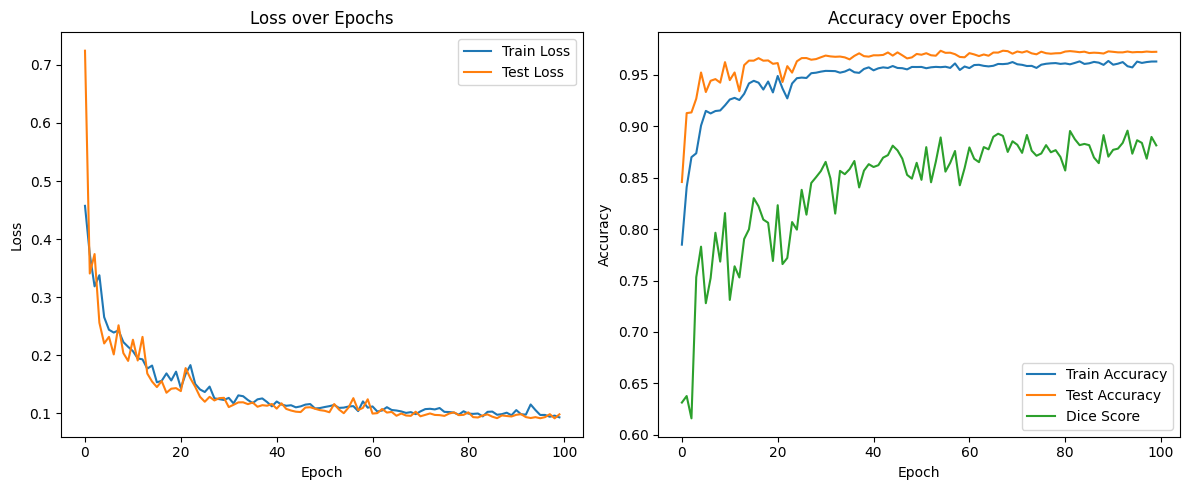

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(val_dice_scores,label = "Dice Score")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


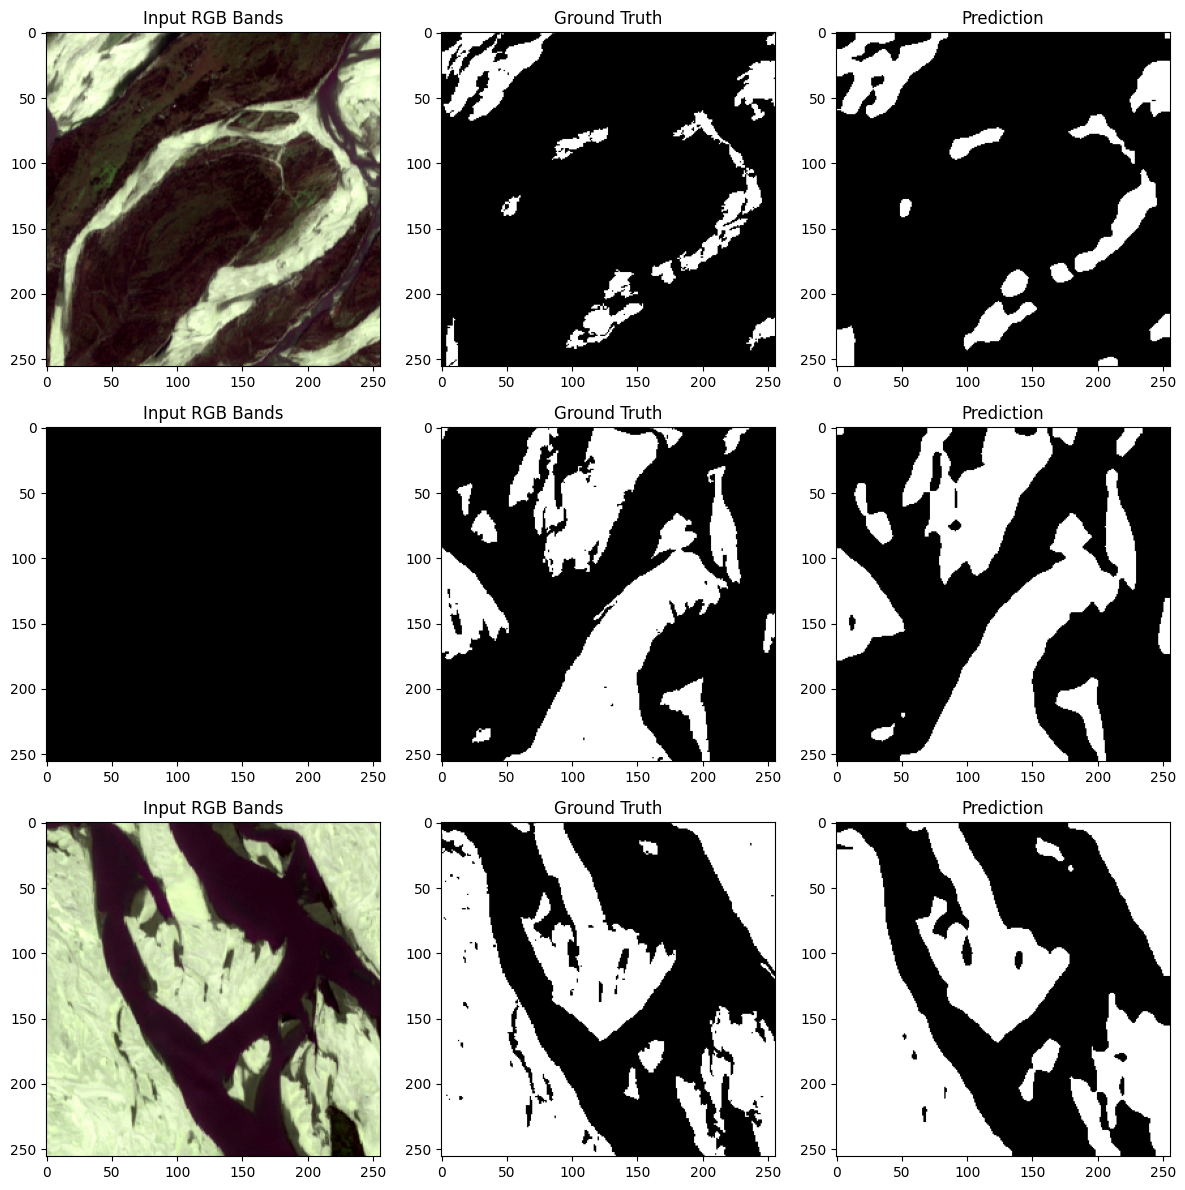

In [38]:
def visualize_predictions(model, dataset, num_samples=3, rgb_indices=(1,2,0)):
    # Use the wrapped model for evaluation
    model.eval()
    idxs = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12,4*num_samples))

    for i, idx in enumerate(idxs):
        image, mask = dataset[idx]  # image:(8,H,W), mask:(H,W)

        # Select correct RGB bands
        # Make sure image is on CPU and is a numpy array before slicing and processing
        img3 = image[list(rgb_indices)].cpu().numpy()
        img3 = np.clip(img3, a_min=np.percentile(img3, 1), a_max=np.percentile(img3, 99))
        img3 = (img3 - img3.min()) / (img3.max() - img3.min() + 1e-6)

        # Predict using the WRAPPED model
        with torch.no_grad():
            # Pass the image through the wrapped_model
            pred = torch.sigmoid(model(image.unsqueeze(0).to(device)))
            pred = (pred.squeeze().cpu().numpy() > 0.5)

        # Display
        axes[i,0].imshow(np.transpose(img3, (1,2,0)))
        axes[i,0].set_title("Input RGB Bands")
        axes[i,1].imshow(mask.squeeze().cpu().numpy(), cmap='gray') # Ensure mask is on CPU and is numpy
        axes[i,1].set_title("Ground Truth")
        axes[i,2].imshow(pred, cmap='gray')
        axes[i,2].set_title("Prediction")

    plt.tight_layout()
    plt.show()

# Call the function with the WRAPPED model
visualize_predictions(wrapped_model, test_dataset, num_samples=3)

In [39]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
print("Best model loaded from file.")

Best model loaded from file.


In [40]:
import torch.nn.functional as F

def sliding_window_inference(image_tensor, model, patch_size=256, threshold=0.4):
    model.eval()
    device = next(model.parameters()).device
    _, H, W = image_tensor.shape
    pred_mask = torch.zeros((H, W), dtype=torch.float32)

    with torch.no_grad():
        stride = patch_size
        for i in range(0, H, stride):
            for j in range(0, W, stride):
                i_end = min(i + patch_size, H)
                j_end = min(j + patch_size, W)

                patch = image_tensor[:, i:i_end, j:j_end]

                # Pad if patch is smaller than patch_size
                pad_h = patch_size - patch.shape[1]
                pad_w = patch_size - patch.shape[2]
                patch = F.pad(patch, (0, pad_w, 0, pad_h), mode='reflect')

                patch = patch.unsqueeze(0).to(device)
                output = model(patch)

                if output.shape[1] == 1:
                    probs = torch.sigmoid(output)
                    pred = (probs > threshold).float()
                elif output.shape[1] == 2:
                    probs = torch.softmax(output, dim=1)
                    pred = (probs[:, 1, :, :] > 0.5).float().unsqueeze(1)
                else:
                    raise ValueError(f"Unexpected output shape: {output.shape}")

                pred = pred.squeeze().cpu()
                pred = pred[:i_end - i, :j_end - j]  # crop padding

                pred_mask[i:i_end, j:j_end] = pred

    return pred_mask


Inference on the full image

In [42]:
# ipython-input-39-dca9bb3a0707
# Load the state dictionary back into the internal model of the wrapped model
wrapped_model.model.load_state_dict(torch.load(best_model_path))
wrapped_model.eval() # Set the wrapped model to evaluation mode
print("Best model loaded from file.")

# ipython-input-41-dca9bb3a0707

def normalize_image(img):
    norm_img = np.empty_like(img, dtype=np.float32)

    # Optical (0-2)
    norm_img[0:3] = img[0:3] / 255.0

    # SAR (3-4): Min-Max normalization
    for idx in range(3, 5):
        b_min, b_max = img[idx].min(), img[idx].max()
        norm_img[idx] = (img[idx] - b_min) / (b_max - b_min + 1e-8)

    # Normalized Indices (5-6): From [-1, 1] to [0, 1]
    norm_img[5:7] = (img[5:7] + 1.0) / 2.0

    return norm_img

# Load image
image_path = "/content/drive/MyDrive/FirstDeepLearningProject/Input_7band.tif"
with rasterio.open(image_path) as src:
    image_array = src.read()  # [7, H, W]
    image_array = normalize_image(image_array)

# Convert to torch tensor
image_tensor = torch.tensor(image_array, dtype=torch.float32).to(device)

# Run sliding window inference using the WRAPPED model
pred_mask = sliding_window_inference(image_tensor, wrapped_model, patch_size=256)

# Convert prediction to NumPy
full_pred_mask = pred_mask.cpu().numpy()

# Load ground truth mask
mask_path = "/content/drive/MyDrive/FirstDeepLearningProject/BarLabel.tif"
with rasterio.open(mask_path) as src:
    ground_truth_mask = src.read(1)

Best model loaded from file.


In [43]:
# 1. Dice Coefficient
def dice_coefficient(preds, masks):
    preds = preds.flatten()
    masks = masks.flatten()
    intersection = ((preds == 1) & (masks == 1)).sum()
    return 2.0 * intersection / ((preds == 1).sum() + (masks == 1).sum() + 1e-7)

# 2. Boundary IoU
def boundary_iou(preds, masks, dilation_radius=1):
    struct = nd.generate_binary_structure(2, 1)
    boundary_pred = np.logical_xor(preds, nd.binary_erosion(preds, structure=struct))
    boundary_mask = np.logical_xor(masks, nd.binary_erosion(masks, structure=struct))

    if dilation_radius > 0:
        boundary_pred = nd.binary_dilation(boundary_pred, structure=struct, iterations=dilation_radius)
        boundary_mask = nd.binary_dilation(boundary_mask, structure=struct, iterations=dilation_radius)

    intersection = np.logical_and(boundary_pred, boundary_mask).sum()
    union = np.logical_or(boundary_pred, boundary_mask).sum()

    return intersection / (union + 1e-7)
# mIOU



def compute_miou_torch(pred_mask, true_mask, threshold=0.5):
    # Assume pred_mask and true_mask are torch.Tensor of shape [B, H, W]
    pred_binary = (pred_mask > threshold).int()
    true_binary = true_mask.int()

    miou_metric = BinaryJaccardIndex()
    miou = miou_metric(pred_binary, true_binary)
    return miou.item()
# Assuming pred is torch.Tensor from model output [1, 1, H, W]
# and gt_mask is the ground truth mask [1, H, W]







In [44]:
# Correct the variables used for calculating metrics
y_true = ground_truth_mask.flatten() # Use the mask loaded from the .tif file
y_pred = full_pred_mask.flatten()

# Convert NumPy arrays to PyTorch tensors before passing to the function
pred_mask_tensor = torch.tensor(full_pred_mask.squeeze(), dtype=torch.float32) # Or appropriate dtype
gt_mask_tensor = torch.tensor(ground_truth_mask.squeeze(), dtype=torch.int64) # Use int64 for labels


iou = jaccard_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
dice = dice_coefficient(full_pred_mask, ground_truth_mask) # Use the correct mask variable
b_iou = boundary_iou(full_pred_mask == 1, ground_truth_mask == 1)

# Pass the PyTorch tensors to the function
miou = compute_miou_torch(pred_mask_tensor, gt_mask_tensor)

# 5. Print results
print(f"IoU Score: {iou:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Boundary IoU: {b_iou:.4f}")
print(f"Mean IoU: {miou:.4f}")

IoU Score: 0.8618
F1 Score: 0.9258
Dice Coefficient: 0.9258
Boundary IoU: 0.3069
Mean IoU: 0.8618


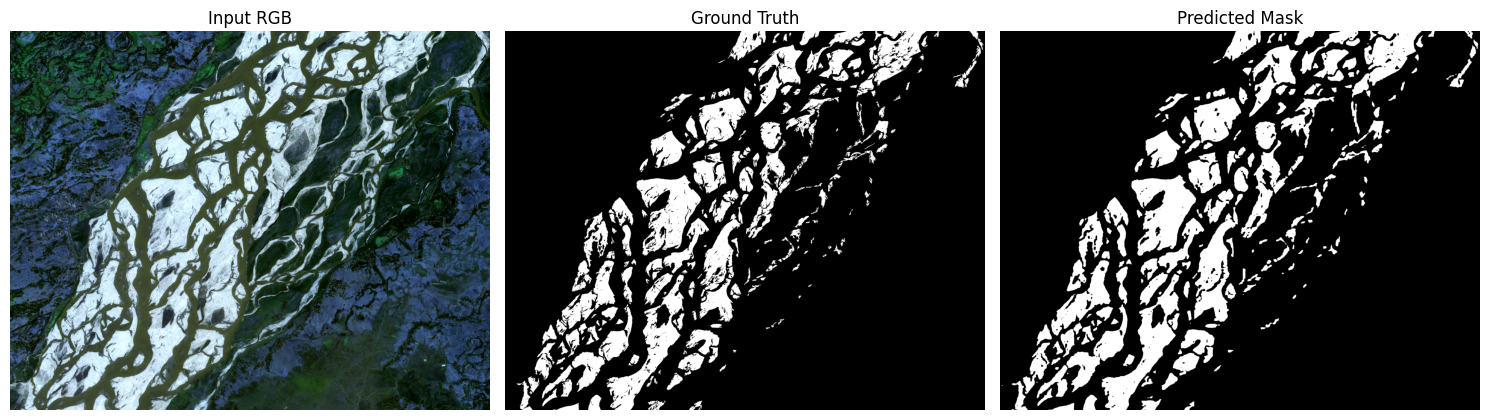

In [45]:
with rasterio.open("/content/drive/MyDrive/FirstDeepLearningProject/Input_7band.tif") as src:
    image_array_raw = src.read()  # [7, H, W]

# Use raw optical bands and normalize for display
rgb_image = image_array_raw[0:3].astype(np.float32)
rgb_image = np.transpose(rgb_image, (1, 2, 0))  # [H, W, 3]

# Stretch to 0–1 using min-max scaling
rgb_min = np.percentile(rgb_image, 2)
rgb_max = np.percentile(rgb_image, 98)
rgb_image = (rgb_image - rgb_min) / (rgb_max - rgb_min + 1e-8)


rgb_image = np.clip(rgb_image, 0, 1)  # Clip to [0, 1] to avoid overflow

# Convert full_pred_mask to float32 if not already
prediction = full_pred_mask.astype(np.float32)

# Load ground truth mask (assumed already loaded as `mask`)
# Use the already loaded ground_truth_mask numpy array
ground_truth = ground_truth_mask.astype(np.float32) # Use the correct variable

# --- Visualization ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.savefig("Unet_CNN_Output.png")
plt.show()

In [ ]:
prediction.shape

(1996, 2531)

In [ ]:
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape

In [ ]:
binary_mask = (full_pred_mask.squeeze() > 0.5).astype('uint8')

def mask_to_polygon(mask,transfrom,crs):
  results = []
  for geom,val in shapes(mask, mask=mask.astype(bool), transform=transform):
    if val==1:
      results.append(shape(geom))
  return gpd.GeoDataFrame(geometry=results,crs=crs)

with rasterio.open("/content/drive/MyDrive/FirstDeepLearningProject/Input_7band.tif") as src:
    transform = src.transform
    crs = src.crs

gdf = mask_to_polygon(binary_mask, transform, crs)
gdf.to_file("alluvial_bars.shp")
